**Target:**
- Apply Batch Normalization, Global Average Pooling and initial dropout of 25%

**Result:**
- Total Parameters: 6070
- Train Accuracy: 98.55% (Epoch - 14)
- Test Accuracy: 98.43% (Epoch - 14)

**Analysis:**
- No overfitting this time around.
- Train and Test Accuracy has reduced slightly compared to that of Step-1 and Step-2 but with a drastic reduction in total number of parameters which is now 6,070.
- Batch Normalization, GAP and dropout has helped preserve almost similar accuracy with slight reduction in total number of parameters but the target of accuracy >= 99.4% isn't achieved yet.
- Need to increase parameter count upto 8k and try other techniques like Image augmentation and/or learning rate scheduler.


**Receptive Field Calculation:**
```
Cin - Input Image Dimension
Rin - Initial Receptive field
Kernel - Size of kernel
Padding - Padding size 
Jin - Jump in
Jout - Jump output
RFnew - New Receptive field
Cout - Output Image dimension after convolution
Layers - Layer name
``` 


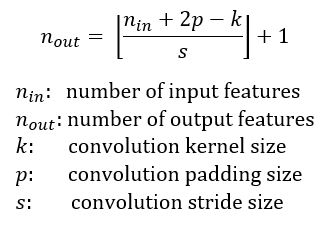


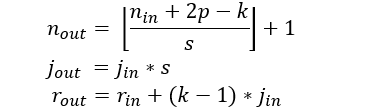

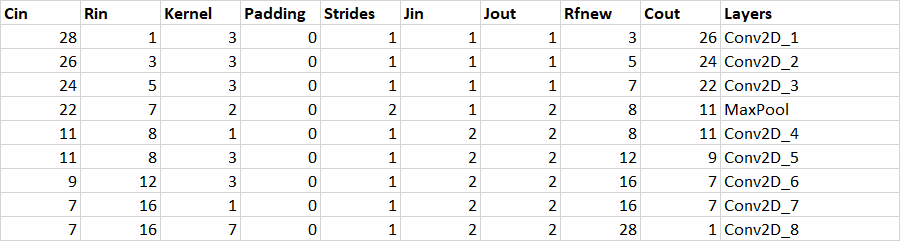

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [ ]:
SEED = 42

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? False


/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([64, 1, 28, 28])
torch.Size([64])


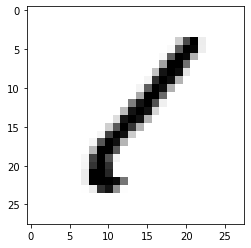

In [ ]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


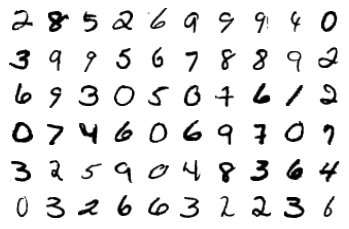

In [ ]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 24
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(20),
            nn.ReLU()
        ) # output_size = 22

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 11

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 9
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(20),
            nn.ReLU()
        ) # output_size = 7

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 7
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=7)
        ) # output_size = 1

        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.dropout(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.dropout(x)
        x = self.convblock7(x)
        x = self.gap(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
       BatchNorm2d-2           [-1, 10, 26, 26]              20
              ReLU-3           [-1, 10, 26, 26]               0
            Conv2d-4           [-1, 10, 24, 24]             900
       BatchNorm2d-5           [-1, 10, 24, 24]              20
              ReLU-6           [-1, 10, 24, 24]               0
            Conv2d-7           [-1, 20, 22, 22]           1,800
       BatchNorm2d-8           [-1, 20, 22, 22]              40
              ReLU-9           [-1, 20, 22, 22]               0
          Dropout-10           [-1, 20, 22, 22]               0
        MaxPool2d-11           [-1, 20, 11, 11]               0
           Conv2d-12           [-1, 10, 11, 11]             200


In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [ ]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=0.1694844365119934 Batch_id=937 Accuracy=86.69: 100%|██████████| 938/938 [01:23<00:00, 11.21it/s]



Test set: Average loss: 0.2952, Accuracy: 9427/10000 (94.27%)

EPOCH: 1


Loss=0.33449649810791016 Batch_id=937 Accuracy=96.42: 100%|██████████| 938/938 [01:16<00:00, 12.25it/s]



Test set: Average loss: 0.1631, Accuracy: 9650/10000 (96.50%)

EPOCH: 2


Loss=0.09673549234867096 Batch_id=937 Accuracy=97.03: 100%|██████████| 938/938 [01:15<00:00, 12.40it/s]



Test set: Average loss: 0.1519, Accuracy: 9629/10000 (96.29%)

EPOCH: 3


Loss=0.16109097003936768 Batch_id=937 Accuracy=97.50: 100%|██████████| 938/938 [01:19<00:00, 11.85it/s]



Test set: Average loss: 0.1309, Accuracy: 9639/10000 (96.39%)

EPOCH: 4


Loss=0.1294776052236557 Batch_id=937 Accuracy=97.66: 100%|██████████| 938/938 [01:13<00:00, 12.84it/s]



Test set: Average loss: 0.0991, Accuracy: 9753/10000 (97.53%)

EPOCH: 5


Loss=0.0937131941318512 Batch_id=937 Accuracy=97.87: 100%|██████████| 938/938 [01:15<00:00, 12.36it/s]



Test set: Average loss: 0.1047, Accuracy: 9737/10000 (97.37%)

EPOCH: 6


Loss=0.11258594691753387 Batch_id=937 Accuracy=97.99: 100%|██████████| 938/938 [01:13<00:00, 12.72it/s]



Test set: Average loss: 0.0940, Accuracy: 9754/10000 (97.54%)

EPOCH: 7


Loss=0.09134550392627716 Batch_id=937 Accuracy=98.11: 100%|██████████| 938/938 [01:13<00:00, 12.85it/s]



Test set: Average loss: 0.0705, Accuracy: 9815/10000 (98.15%)

EPOCH: 8


Loss=0.008592015132308006 Batch_id=937 Accuracy=98.21: 100%|██████████| 938/938 [01:13<00:00, 12.71it/s]



Test set: Average loss: 0.0782, Accuracy: 9789/10000 (97.89%)

EPOCH: 9


Loss=0.09639772772789001 Batch_id=937 Accuracy=98.29: 100%|██████████| 938/938 [01:12<00:00, 12.98it/s]



Test set: Average loss: 0.0652, Accuracy: 9824/10000 (98.24%)

EPOCH: 10


Loss=0.06893656402826309 Batch_id=937 Accuracy=98.38: 100%|██████████| 938/938 [01:12<00:00, 12.86it/s]



Test set: Average loss: 0.0670, Accuracy: 9809/10000 (98.09%)

EPOCH: 11


Loss=0.09681819379329681 Batch_id=937 Accuracy=98.39: 100%|██████████| 938/938 [01:16<00:00, 12.32it/s]



Test set: Average loss: 0.0527, Accuracy: 9867/10000 (98.67%)

EPOCH: 12


Loss=0.03950345143675804 Batch_id=937 Accuracy=98.45: 100%|██████████| 938/938 [01:13<00:00, 12.81it/s]



Test set: Average loss: 0.0575, Accuracy: 9850/10000 (98.50%)

EPOCH: 13


Loss=0.2284093052148819 Batch_id=937 Accuracy=98.50: 100%|██████████| 938/938 [01:14<00:00, 12.56it/s]



Test set: Average loss: 0.0485, Accuracy: 9870/10000 (98.70%)

EPOCH: 14


Loss=0.04177158698439598 Batch_id=937 Accuracy=98.55: 100%|██████████| 938/938 [01:16<00:00, 12.26it/s]



Test set: Average loss: 0.0522, Accuracy: 9843/10000 (98.43%)

